# Dependencies 

In [5]:
import pandas as pd 
import numpy as np
import torch 

from torch import nn, optim
from dataset import Dataset, Batch
from utils import standardize
from feature_engineering import datetime_to_vec

from typing import Iterable

# Overview 
In this notebook we will train a simple LSTM-based neural network to predict the average pollution in New Delhi from weather and time features. 

# Data
Below we obtain weather and PM 2.5. We also instantiate a Dataset object which will additionally engineer time features using the datetime_to_vec function.

In [11]:
weather = pd.read_csv(
    '../TF/data/delhi_weather_processed', 
    index_col='timestamp', 
    parse_dates=['timestamp'],
)
weather_scaler = standardize(
    weather, 
    ['Temperature', 'Pressure', 'Humidity', 'Wind Speed', 'Visibility', 'Dewpoint'],
)

pm_gps = pd.read_csv(
    '../TF/data/DAP_CPCB_all', 
    index_col='timestamp', 
    parse_dates=['timestamp'],
)
pm_gps_scaler = standardize(
    pm_gps, 
    ['pm2_5'],
)

n_train = int(len(pm_gps) * 0.8)
dataset_train = Dataset(
    pm_gps=pm_gps.iloc[:-n_train], 
    snapshot_minutes=15, 
    weather=weather, 
    minutes_to_weather=15,
    datetime_to_vec=datetime_to_vec,
)
dataset_test = Dataset(
    pm_gps=pm_gps.iloc[-n_train:], 
    snapshot_minutes=15, 
    weather=weather, 
    minutes_to_weather=15, 
    datetime_to_vec=datetime_to_vec,
)

C:\Users\wyrwa\Speckled\report\dataset.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[temp_col_name] = list(map(tuple, df[columns].values))
C:\Users\wyrwa\Speckled\report\dataset.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[temp_col_name] = list(map(tuple, df[columns].values))


In [6]:
def batch_to_labels(batch: Batch) -> torch.Tensor:
    """
    Returns the average pm value per snapshot for the given batch.
    """
    return torch.Tensor([snapshot.pm.mean() for snapshot in batch]).view(-1, 1)


def batch_to_inputs(batch: Batch) -> torch.Tensor:
    """
    Returns the concatenated weather and time featuers for the given batch.
    """
    n = batch[0].weather.size + batch[0].time.size
    return torch.from_numpy(
        np.array([np.concatenate((snapshot.weather, snapshot.time)) for snapshot in batch])
    )

# Model
The model below is very simple, since at the time of writing it was a proof of concept. One might want to add skip connections, dropout, and/or convolutional layers to improve the model's performance. 

In [7]:
torch.set_default_dtype(torch.float64)


class RNN(nn.Module): 
    """
    Recursive Neural Network consisting of two LSTM fully connected layers followed by a fully connected 
    linear layer. 
    """
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super(RNN, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.lin = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Required input shape is [batch size, number of features]
        """
        o, hc = self.lstm1(x)
        o, hc = self.lstm2(o, hc)
        o = self.lin(o)
        return o 

# Example

In [8]:
from tqdm.notebook import tqdm

### Training loop 

In [12]:
dataset = dataset_train
EPOCHS = 100

model = RNN(len(dataset[0][0].weather) + len(dataset[0][0].time), 75, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


model.train() 
for epoch in tqdm(range(1, EPOCHS+1)):
    total_loss = 0
    for batch in dataset: 
        x, y = batch_to_inputs(batch), batch_to_labels(batch)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward() 
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.detach().item()
    print(f'Epoch {epoch}: loss={total_loss}', end='\r')

  0%|          | 0/100 [00:00<?, ?it/s]

### Plotting results

In [13]:
from matplotlib import pyplot as plt 

In [14]:
def plot_prediction(model, batch, title='Test'):
    model.eval()
    
    x, y = batch_to_inputs(batch), batch_to_labels(batch)
    y_hat = model(x).detach().flatten()
    y = y.detach().flatten()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(y, c='blue', label='target')
    ax.plot(y_hat, c='red', label='prediction')
    
    ax.set_ylabel('Normalized PM 2.5', fontsize=12)
    ax.set_xlabel('Timestep', fontsize=12)
    ax.set_title(title, fontsize=16)
    
    ax.legend(loc='upper left', fontsize=12)
    
    return fig, ax

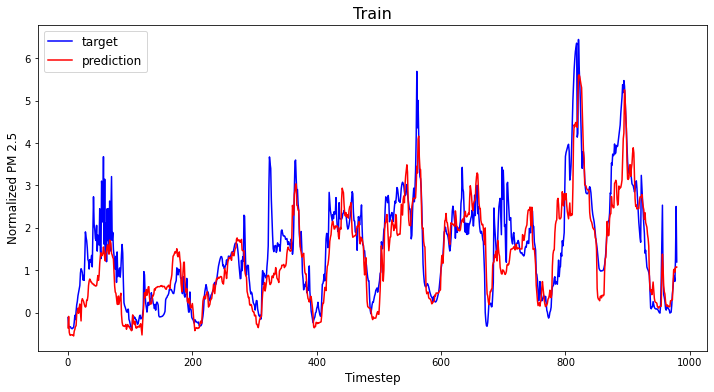

In [22]:
fig, ax = plot_prediction(model, dataset_train[20], title='Train')

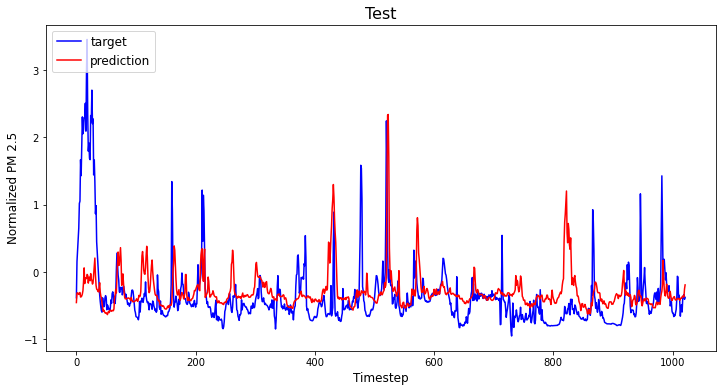

In [23]:
fig, ax = plot_prediction(model, dataset_test[7], title='Test')